Este proyecto contiene una introducción a las incrustaciones de palabras. Entrenaremos nuestras propias incrustaciones de palabras utilizando un modelo Keras sumple para una tarea de clasificación de sentimientos.

### Representar texto como números.

Los modelos de aprendizaje automático toman vectores(matrices de números) como entrada. Cuando trabajamos con texto, lo primero que se debe hacer es pensar en una estrategia para convertir cadenas de texto en números(o "vectorizar" el texto) antes de enviarlo al modelo. Veamos 3 estrategias para hacerlo.

### One-hot encoding.

Como primera idea, podemos codificar "one-hot" cada palabra en el vocabulario. Consideremos la oración "El gato se sentó en la alfombra""The cat sat on mat". El vocabulario(o palabras únicas) en esta oración es (El, gato, se, sentó, en, la, alfombra)(the, cat, sat, on, mat). Para representar cada palabra, creamos un vector cero con una longiutd igual al vocabulario, luego colocamos un uno en el índice que conrresponda a la palabra.

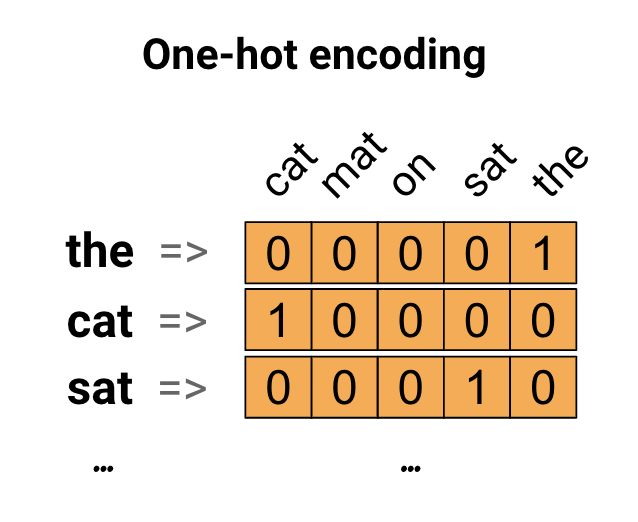

In [2]:
from IPython.display import Image
Image(filename='C:/Users/rodri/OneDrive/Escritorio/Trabajos/Tensorflow/one-hot.png')

Para crear un vector que contenga la codificación de la oración, podemos concatenar los vectores one-hot para cada palabra.

_Punto clave: Este enfoque es ineficiente. Un vector codificado one-hot es escado(lo que significa que la mayoría de los índices son cero). Imaginemos que tenemos 10.000 palabras en el vocabulario. Para codificar en one-hot cada palabra, crearíamos un vector donde el 99,99% de los elementos son cero._

### Codifiquemos cada palabra con un número único.

Un segundo enfoque que podemos probar es codificar cada palabra usando un número único. Continuando con el ejemplo anterior, podemos asigar 1 a 'gato', 2 a 'alfombra', y así sucesivamente. Después podríamos codificar la oración "El gato se sentó en la alfombra" como un vector denso como [5, 1, 4, 3, 5, 2]. Este enfoque es eficiente. En lugar de un vector disperso, ahora tenemos uno denso(donde todos los elementos están llenos).

Pero, tenemos dos desventajas con este enfoque:

* La codificación de enteros es arbitraria(no capta ninguna relación entre palabras)
* La codificación de enteros puede ser difícil de interpretar para un modelo. Un clasificador lineal, por ejemplo, aprende un solo peso para cada característica. Debido a que no existe una relación entre la similitud de dos palabras cualquieras y la similitud de sus codificaciones, esta combinación de características y peso no es significativa.

### Embedding.

El embedding nos brinda una manera de usar una representación densa y eficiente en la que palabras similares tienen una codificación similar. Es importante destacar que no tiene que especificar esta codificación a mano. Un embedding es un vector denso de valores de punto flotante(la longitud del vector es un parámetro que especifica). En lugar de especificar los valores para la incrustación manualmente, son parámetros entrenables(pesos aprendidos por el modelo durante el entrenamiento, de la misma manera que un modelo aprende los pesos de una capa densa). Es común ver embeddings de palabras de 8 dimensiones(para conjuntos de datos pequeños), hasta 1024 dimensiones cuando se trabaja con conjuntos de datos grandes. Un embedding de mayor dimensión puede capturar relaciones detalladas entre palabras, pero requiere más datos para aprender.

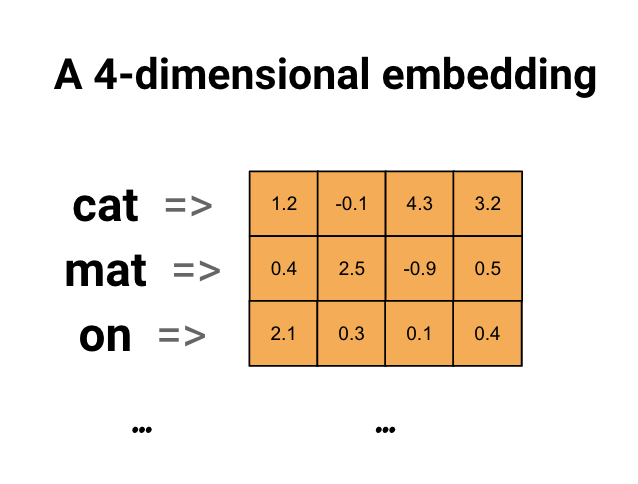

In [3]:
Image(filename='C:/Users/rodri/OneDrive/Escritorio/Trabajos/Tensorflow/embedding2.png')

Ese sería un diagrama de la representación del embedding. Cada palabra se representa como un vecotr de 4 dimensiones de valores de punto flotante. Otra forma de pensar en una incrustación es como una "tabla de búsqueda". Despues de aprender estos pesos, puede codificar cada palabra buscando el vector denso al que corresponde en la tabla.

In [6]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

Para este proyecto, utilizaremos el conjunto de datos de revisión de películas grandes. Entrenaremos un modelo de clasificación de opiniones en este conjunto de datos y, en el proceso, veremos incrustaciones desde cero.

Descarguemos el conjunto de datos usando la utilidad de archivo Keras y veamos los directorios.

In [7]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar = True, cache_dir = '.',
                                  cache_subdir = '')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

Veamos el directorio __train__. Tiene carpetas __pos__ y __neg__ con reseñas de películas etiquetadas como positivas y negativas respectivamente. Utilizaremos las revisiones de las carpetas __pos__ y __neg__ para entrenar un modelo de clasificación binaria.

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

El directorio __train__ también tiene carpetas adicionales que debemos eliminar antes de crear un conjunto de datos de entrenamiento.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Luego, creamos un tf.data.Dataset usando tf.keras.utils.text_dataset_from_directory.

Usamos el directorio de __train__ para crear conjuntos de datos de entrenamiento y validación con una división del 20% para la validación.

In [10]:
batch_size = 1024
seed = 123

train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split = 0.2,
    subset = 'training', seed = seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split = 0.2,
    subset = 'validation', seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Veamos algunas reseñas de películas y sus etiquetas(1 = positivo | 0 = negativo) del conjunto de datos de entrenamiento.

In [11]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

### Configuramos el conjunto de datos para el rendimiento.

Estos son dos métodos importantes que debemos usar al cargar datos para asegurarnos de que la E/S no se bloquee.

.cache() mantiene los datos en la memoria después de que se cargan fuera del disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrenamos el modelo. Si el conjunto de datos es demasiado grande para caber en la memoria, también podemos usar este método para crear un caché en disco de alto rendimiento, que es más eficiente para ller que muchos archivos pequeños.

.prefetch() superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Uso de la capa de embedding

Keras facilita el uso de embedding de palabras.

La capa de embedding se puede entender como una tabla de búsqueda que mapea desde índices enteros(que representan palabras específicas) hasta vectores densos(sus incrustaciones). La dimensionalidad(o ancho) del embedding es un parámetro con el que podemos experimentar para ver que funciona bien para nuestro problema, de la misma manera que experimentaríamos con la cantidad de neuronas en una capa Densa.

In [13]:
# Incrustamos un vocabulario de 1000 palabras en 5 dimensiones.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

Cuando creamos una capa de embedding, los pasos para la incrustación se incializan aleatoriamente(como cualquie otra capa). Durante el entrenamiento, se ajustan gradualmente mediante retropropagación. Una vez entrenadas, las incrustaciones de palabras aprendidas codificarán aproximadamente las similitudes entre las palabras(como se aprendieron para el problema específico en el que se entrenó el modelo).

Si pasamos un entero a una capa de embedding, el resultado reemplaza cada entero con el vector de la tabla de incrustación.

In [14]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.02564209,  0.03439919, -0.0053378 , -0.03337228, -0.03501927],
       [-0.04724643, -0.02205271, -0.02927967, -0.02157116,  0.01116778],
       [-0.04112965,  0.02086431, -0.00610803, -0.03350763, -0.03808688]],
      dtype=float32)

Para problemas de texto o secuencia, la capa embedding toma un tensor 2D de números enteros, de forma(samples, sequence_length), donde cada entrada es una secuiencia de números enteros. Podemos incrustar secuencias de longitud variable. Podemos alimentar la capa de embedding por encima de lotes con formas (32, 10)(lote de 32 secuencias de longitud 10) o (64, 15)(lote de 64 secuencias de longitud 15)

El tensor devuelto tiene un eje más que la entrada, los vecotres de embedding se alinan a lo largo del nuevo último eje. Pasemos un lote de entrada(2, 3) y la salida es (2, 3, N)

In [15]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

Cuando se le da a un lote de secuencias como entrada, una capa de incrustación devuelve un tensor de coma flotante 3D, de forma(samples, sequence_length, embedding_dimensionality). Para convertir esta secuencia de longitud variable en una representación fija, existe una variedad de enfoques estándar. Podemos usar una capa RNN, de atención o de agrupación antes de pasarla a una capa densa. Este proyecto utiliza la agrupación porque es el más simple.

### Procesamiento de texto.

Definimos los pasos de preprocesamiento del conjunto de datos necesarios para nuestro modelo de clasificació de opiniones. Inicializamos una capa de TextVectorization con los parámetros deseados para vectorizar reseñas de películas.

In [17]:
# Función de estandarización personalizada para eliminar las etiquetas de interrupción HTML '<br />'
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

# Tamaño del vocabulario y número de palabras en una secuencia.
vocab_size = 10000
sequence_length = 100

'''

Usamos la capa de vectorización de texto para normalizar, dividir y asignar cadenas a números
enteros. Hay que tener en cuenta que la capa utiliza la estandarización personalizada definida
anteriormente. Establecemos la longitud máxima de secuencia ya que todas las muestras no tienen
la misma longitud.

'''

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

# Creamos un conjunto de datos solo de texto(sin etiquetas) y usamos adapt para desarrollar el vocabulario.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

### Modelo de clasificación.

Usamos la API secuencial de keras para definir el modelo de clasificación de opiniones. En este caso se trata de un modelo de estilo "Bolsa continua de palabras".

* La capa __TextVectorization__ transforma cadenas en índices de vocabulario. Ya inicializamos vectorize_layer como una capa de TextVectorization y construimos su vocabulario llamado __adapt__. Ahora vectorize_layer se puede usar como la capa de nuestro modelo de clasificación de extremo a extremo, alimentando cadenas transformadas en la capa de incrustación.
* La capa de __Embedding__ toma el vocabulario codificado en enteros y busca el vector de incrustación para cada índice de palabra. Estos vectores se aprenden a medida que el modelo se entrena. Los vectores agregan una dimensión a la matriz de salida. Las dimensiones resultantes son: (batch, sequence, embedding).
* La capa __GlobalAvaragePooling1D__ devuelve un vector de salida de longitud fija para cada ejemplo promediando la dimensión de la secuencia. Esto permite que el modelo meneje entradas de longitud variable, de la manera más simple posible.
* El vector de salida de longitud fija se canaliza a través de una capa(Dense) completamente conectada con 16 unidades ocultas.
* La última capa está densamente conectada con un solo nodo de salida.

_IMPORTANTE: Este modelo no usa enmascaramiento, por lo que el relleno cero se usa como parte de la entrada y, por lo tanto, la longitud del relleno puede afectar la salida_

In [18]:
embedding_dim = 16

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name = 'embedding'),
    GlobalAveragePooling1D(),
    Dense(16, activation = 'relu'),
    Dense(1)
])

### Compilar y entrenar el modelo.

Usaremos TensorBoard para visualizar métricas, incluidas la pérdida y la precisión. Creamos un tf.kerasw.callbacks.TensorBoard

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

Compilamos y entrenamos el modelo con el optimizar __Adam__ y la pérdida __BinaryCrossentropy__

In [21]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [22]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 15,
    callbacks = [tensorboard_callback]
)

Epoch 1/15
20/20 [==============================] - 27s 1s/step - loss: 0.6921 - accuracy: 0.5028 - val_loss: 0.6901 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 4s 192ms/step - loss: 0.6868 - accuracy: 0.5028 - val_loss: 0.6836 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 4s 187ms/step - loss: 0.6783 - accuracy: 0.5028 - val_loss: 0.6738 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 4s 186ms/step - loss: 0.6656 - accuracy: 0.5028 - val_loss: 0.6596 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 4s 183ms/step - loss: 0.6476 - accuracy: 0.5028 - val_loss: 0.6406 - val_accuracy: 0.4886
Epoch 6/15
20/20 [==============================] - 4s 210ms/step - loss: 0.6246 - accuracy: 0.5030 - val_loss: 0.6175 - val_accuracy: 0.4900
Epoch 7/15
20/20 [==============================] - 4s 189ms/step - loss: 0.5969 - accuracy: 0.5444 - val_loss: 0.5906 - val_accuracy: 0.5708
Epoch 8/

Con este enfoque, el modelo alcanza una precisión de validación de alrededor del 78%(tengamos en cuenta que el modelo se está sobreajustando ya que la precisión del entrenamiento es mayor.)

_Para tener en cuenta: El resultado de sus modelos pueden ser un poco diferentes, dependiendo de cómo se inicializaron aleatoriamente los pesos antes de entrenar la capa de incrustación._

Podemos consultar el resumen del modelo para obtener más información sobre cada capa del modelo.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trai

Visualizamos las métricas del modelo en TensorBoard.

In [25]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs

### Recuperemos los embeddings de palabras entrenadas y las guardamos en el disco.

Las incrustaciones son pesos de la capa de incrustación en el modelo. La matriz de ponderaciones tiene la forma (vocab_size, embedding_dimesion).

Obtengamos los pesos del modelo usando get_layer() y get_weights(). La función get_vocabulary() proporciona el vocabulario para crear un archivo de metadatos con un token por línea.

In [26]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

Escribamos los pesos en el disco. Para utilizar el proyector de incrustaciones, debemos cargar dos archivos en formato separado por tabulaciones: un archivo de vectores(que contiene la incrustación) y un archivo de metadatos(que contiene las palabras).

In [27]:
out_v = io.open('vector.tsv', 'w', encoding = 'utf-8')
out_m = io.open('metadata.tsv', 'w', encoding = 'utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

_Nota: Por lo general, se necesita un conjunto de datos mucho más grande para entrenar incrustaciones de palabras más interpretes. Este proyecto utiliza un pequeño conjunto de datos de IMDb con fines de demostración._